<a href="https://colab.research.google.com/github/maxpilling/AI/blob/master/image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image Classification with Convolutional Neural Networks 

In [ ]:
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
from  torch.utils.data import Dataset

from sklearn.metrics import confusion_matrix
from skimage import io, transform

import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import pandas as pd
import numpy as np
import csv
import os
import math
import cv2

### Part I

In [ ]:
# ! rm -r imagenet10/
! git clone https://github.com/MohammedAlghamdi/imagenet10.git

Cloning into 'imagenet10'...
remote: Enumerating objects: 10019, done.
remote: Total 10019 (delta 0), reused 0 (delta 0), pack-reused 10019
Receiving objects: 100% (10019/10019), 966.71 MiB | 25.02 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (10002/10002), done.


Check that the repository is there:

In [ ]:
! ls

imagenet10  sample_data


In [ ]:
root_dir = "imagenet10/train_set/"
class_names = [
  "baboon",
  "banana",
  "canoe",
  "cat",
  "desk",
  "drill",
  "dumbbell",
  "football",
  "mug",
  "orange",
]

A helper function for reading in images and assigning labels.

In [ ]:
def get_meta(root_dir, dirs):
    """ Fetches the meta data for all the images and assigns labels.
    """
    paths, classes = [], []
    for i, dir_ in enumerate(dirs):
        for entry in os.scandir(root_dir + dir_):
            if (entry.is_file()):
                paths.append(entry.path)
                classes.append(i)
                
    return paths, classes

Now we create a dataframe using all the data.

In [ ]:
# Benign images we will assign class 0, and malignant as 1
paths, classes = get_meta(root_dir, class_names)

data = {
    'path': paths,
    'class': classes
}

data_df = pd.DataFrame(data, columns=['path', 'class'])
data_df = data_df.sample(frac=1).reset_index(drop=True) # Shuffles the data

View some sample data.

In [ ]:
print("Found", len(data_df), "images.")
data_df.head()

Found 9000 images.


,path,class
0,imagenet10/train_set/canoe/n02951358_5118.JPEG,2
1,imagenet10/train_set/football/n04254680_5365.JPEG,7
2,imagenet10/train_set/orange/n07747607_4103.JPEG,9
3,imagenet10/train_set/mug/n03797390_5061.JPEG,8
4,imagenet10/train_set/canoe/n02951358_10047.JPEG,2


Now we will create the Dataset class.

In [ ]:
class ImageNet10(Dataset):
    """ ImageNet10 dataset. """

    def __init__(self, df, transform=None):
        """
        Args:
            image_dir (string): Directory with all the images
            df (DataFrame object): Dataframe containing the images, paths and classes
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load image from path and get label
        x = Image.open(self.df['path'][index])
        try:
          x = x.convert('RGB') # To deal with some grayscale images in the data
        except:
          pass
        y = torch.tensor(int(self.df['class'][index]))

        if self.transform:
            x = self.transform(x)

        return x, y

Compute what we should normalise the dataset to.

In [ ]:
def compute_img_mean_std(image_paths):
    """
        Author: @xinruizhuang. Computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means, stdevs


In [ ]:
norm_mean, norm_std = compute_img_mean_std(paths)

100%|██████████| 9000/9000 [00:43<00:00, 209.07it/s]


(224, 224, 3, 9000)
normMean = [0.52283835, 0.47988674, 0.40605244]
normStd = [0.2977063, 0.28884053, 0.3117812]


Now let's create the transforms to normalise and turn our data into tensors.

In [ ]:
data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std),
    ])

Let's split the data into train and test sets and instantiate our new ISIC_Dataset objects.

In [ ]:
train_split = 0.70 # Defines the ratio of train/valid/test data.
valid_split = 0.10

train_size = int(len(data_df)*train_split)
valid_size = int(len(data_df)*valid_split)

ins_dataset_train = ImageNet10(
    df=data_df[:train_size],
    transform=data_transform,
)

ins_dataset_valid = ImageNet10(
    df=data_df[train_size:(train_size + valid_size)].reset_index(drop=True),
    transform=data_transform,
)

ins_dataset_test = ImageNet10(
    df=data_df[(train_size + valid_size):].reset_index(drop=True),
    transform=data_transform,
)

You will need to create DataLoaders for the datasets.

In [ ]:
train_loader = torch.utils.data.DataLoader(
    ins_dataset_train,
    batch_size=16,
    shuffle=True,
    num_workers=2
)

valid_loader = torch.utils.data.DataLoader(
    ins_dataset_valid,
    batch_size=16,
    shuffle=True,
    num_workers=2
)


test_loader = torch.utils.data.DataLoader(
    ins_dataset_test,
    batch_size=24,
    shuffle=False,
    num_workers=2
)

A framework for the ConvNet model, missing all layers except the final fully-connected layer:

In [ ]:
# Convolutional neural network
class ConvNet(nn.Module):
    
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
  
        # Add network layers here
        self.cnn_layers = nn.Sequential(
            # Convolution 1
            nn.Conv2d(3, 16, kernel_size=(3,3)),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Dropout(p=0.3),
            
            # Convolution 2
            nn.Conv2d(16, 24, kernel_size=(4,4)),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Dropout(p=0.3),

            # Convolution 3
            nn.Conv2d(24, 32, kernel_size=(4,4)),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Dropout(p=0.3),

            nn.Flatten(),
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(26912, 512),
            nn.Linear(512, num_classes),
        )

        # self.final = nn.Softmax(dim=1)
        
    def forward(self, x):

        # Complete the graph
        out = self.cnn_layers(x)
        out = self.linear_layers(out)
        return out

In [ ]:
torch.manual_seed(0)

In [ ]:
model = ConvNet()
model

ConvNet(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(16, 24, kernel_size=(4, 4), stride=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.3, inplace=False)
    (8): Conv2d(24, 32, kernel_size=(4, 4), stride=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.3, inplace=False)
    (12): Flatten()
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=26912, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
model_gpu = ConvNet().to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()

# Stochastic gradient dforward(escent
optimiser = optim.SGD(model_gpu.parameters(), lr=0.001, momentum=0.9)

In [ ]:
def train_model_epochs_wo_val(num_epochs):
  for epoch in range(num_epochs):
    print('Epoch {}/{}:'.format(epoch + 1, num_epochs))
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
      images, labels = data

      # Explicitly specifies that data is to be copied onto the device!
      images = images.to(device)  # <----------- And note it's NOT an in-place operation; original
      labels = labels.to(device)  # <----------- variables still exist on CPU

      # Zero the param gradients
      optimiser.zero_grad()

      # forward pass
      outputs = model_gpu(images)

      # compute loss
      loss = criterion(outputs, labels)

      # backwards pass (backpropagate the error wrt the lossforward)
      loss.backward()

      # update the parameters
      optimiser.step()

      # print the loss
      running_loss += loss.item()
      if i % 100 == 99:    # print every 100 mini-batches
          print('Batch %d - Loss: %.3f' %
                  (i + 1, running_loss / 100))
          running_loss = 0.0

  print('Saving model.')
  if (os.path.exists('./3Conv_wo_val.pt')):
    os.remove('./3Conv_wo_val.pt')
  torch.save(model.state_dict(), './3Conv_wo_val.pt')

In [ ]:
def train_model_epochs_w_val(num_epochs):
  best_val_loss = 100000
  for epoch in range(num_epochs):
    print('Epoch {}/{}:'.format(epoch + 1, num_epochs))
    for phase in ['train', 'val']:
        
      if (phase == 'train'):
        loader = train_loader
      else:
        loader = valid_loader

      running_loss = 0.0

      for i, data in enumerate(loader, 0):
        images, labels = data

        # Explicitly specifies that data is to be copied onto the device!
        images = images.to(device)  # <----------- And note it's NOT an in-place operation; original
        labels = labels.to(device)  # <----------- variables still exist on CPU

        # Zero the param gradients
        optimiser.zero_grad()

        # forward pass
        outputs = model_gpu(images)

        # compute loss
        loss = criterion(outputs, labels)

        if phase == 'train':
          # backwards pass (backpropagate the error wrt the lossforward)
          loss.backward()
          # update the parameters
          optimiser.step()

        # print the loss
        running_loss += loss.item()

        if i % 100 == 99:    # print every 100 mini-batches
            print('Batch %d - Loss: %.3f' %
                  (i + 1, running_loss / 100))
            running_loss = 0.0

      if phase == 'val':
          print('Validation loss: {}'.format(running_loss))
          if (running_loss < best_val_loss):
            print('Saving model.')
            best_val_loss = running_loss
            if (os.path.exists('./3Conv_w_val.pt')):
              os.remove('./3Conv_w_val.pt')
            torch.save(model.state_dict(), './3Conv_w_val.pt')
          print('-' * 20)

In [ ]:
import timeit

cpu_train_time = timeit.timeit(
    "train_model_epochs_wo_val(num_epochs)",
    setup="num_epochs=10",
    number=1,
    globals=globals(),
)

Epoch 1/10:
Batch 100 - Loss: 2.223
Batch 200 - Loss: 1.970
Batch 300 - Loss: 1.890
Epoch 2/10:
Batch 100 - Loss: 1.747
Batch 200 - Loss: 1.692
Batch 300 - Loss: 1.685
Epoch 3/10:
Batch 100 - Loss: 1.619
Batch 200 - Loss: 1.629
Batch 300 - Loss: 1.551
Epoch 4/10:
Batch 100 - Loss: 1.472
Batch 200 - Loss: 1.510
Batch 300 - Loss: 1.517
Epoch 5/10:
Batch 100 - Loss: 1.390
Batch 200 - Loss: 1.403
Batch 300 - Loss: 1.397
Epoch 6/10:
Batch 100 - Loss: 1.301
Batch 200 - Loss: 1.306
Batch 300 - Loss: 1.279
Epoch 7/10:
Batch 100 - Loss: 1.187
Batch 200 - Loss: 1.140
Batch 300 - Loss: 1.165
Epoch 8/10:
Batch 100 - Loss: 0.998
Batch 200 - Loss: 1.068
Batch 300 - Loss: 1.043
Epoch 9/10:
Batch 100 - Loss: 0.957
Batch 200 - Loss: 0.887
Batch 300 - Loss: 0.956
Epoch 10/10:
Batch 100 - Loss: 0.747
Batch 200 - Loss: 0.843
Batch 300 - Loss: 0.834
Saving model.


In [ ]:
cpu_train_time

475.915616662

In [ ]:
ConvNet = torch.load('./3Conv_wo_val.pt',  map_location=lambda storage, loc: storage)

In [ ]:
correct = 0
total = 0
tot_predicted = torch.zeros(0,dtype=torch.long, device='cpu')
tot_labels    = torch.zeros(0,dtype=torch.long, device='cpu')
# tot_predicted = torch.Tensor()
# Why don't we need gradients? What happens if we do include gradients?
with torch.no_grad():
    # Iterate over the test set
    i = 0
    for i, data in enumerate(test_loader, 0):
        # print('iteration {}'.format(i))
      
        images, labels = data

        images = images.to(device)  # <----------- And note it's NOT an in-place operation; original
        labels = labels.to(device)  # <----------- variables still exist on CPU
        
        outputs = model_gpu(images)
        
        # torch.max is an argmax operation
        _, predicted = torch.max(outputs.data, 1)
        # print(predicted.cpu())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Append batch prediction results
        tot_predicted = torch.cat([tot_predicted, predicted.view(-1).cpu()])
        tot_labels    = torch.cat([tot_labels,    labels.view(-1).cpu()])


print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 54 %


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(tot_labels.numpy(), tot_predicted.numpy())
cm

array([[109,   2,   7,  50,   2,   0,  13,   2,   2,   1],
       [  7,  97,   1,  21,   7,   1,   9,  12,   8,  13],
       [  2,   3, 123,   7,  16,   4,  13,   8,   8,   3],
       [ 23,   5,   3, 119,   3,   2,   7,  10,   5,   1],
       [  1,   5,   8,   2, 100,  11,  17,   5,  17,   3],
       [  2,   4,   5,   8,  28,  59,  46,   7,  25,   0],
       [  1,   2,   5,   6,  26,  11,  86,   8,  17,   0],
       [  9,   9,  14,  19,  11,   3,  19,  84,  14,   6],
       [  5,  11,   9,   7,  17,   3,  28,  12,  88,   2],
       [  1,  30,   3,  10,   5,   0,   4,   2,   7, 124]])

In [ ]:
import itertools

def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix very prettily.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    # Specify the tick marks and axis text
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    # The data formatting
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Print the text of the matrix, adjusting text colour for display
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

Confusion matrix, without normalization


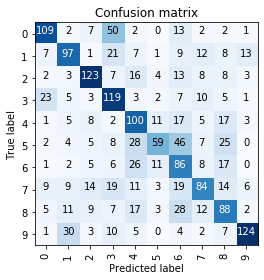

In [ ]:
plot_confusion_matrix(cm, np.arange(0,10))